In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../Style.mplstyle')
import pandas as pd
import os
import sys
import scipy
from iminuit import Minuit
from scipy import stats
sys.path.append('..')
from read_data_functions import *
from plot_functions import *
from calculations import *

In [2]:
parent_path = '../../../../'
path = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/Lund/'

SMPS = read_SMPS(path, parent_path, [0, 0])
OPS_APS = read_OPS(path, parent_path, 0)

NS_dict_keys = ['2024-10-15_NanoScan', '2024-10-16_NanoScan', '2024-10-17_NanoScan']
NS_bins = SMPS['2024-10-21_NanoScan'].keys()[3:16].to_list()

NS_bg_mean, NS_bg_std, NS_bg_error = bin_mean(['2024/10/21 11:45:00', '2024/10/21 14:10:00'], 
                                              SMPS['2024-10-21_NanoScan'], NS_bins, 'Time', 0.1)

for key in NS_dict_keys:
    df = SMPS[key]
    for i, bin in enumerate(NS_bins):
        df[bin] = df[bin] - NS_bg_mean[i]

    SMPS[key] = df

dict_keys = ['Exp1', 'Exp2', 'Exp3', 'Exp4']
OPS_mid_point = [0.337, 0.419, 0.522, 0.650, 0.809, 1.007, 1.254, 1.562, 1.944, 2.421, 3.014, 3.752, 4.672, 5.816, 7.241, 9.015]
OPS_bins = OPS_APS['Exp1'].keys()[1:17].to_list()

for dict_key in dict_keys:
    for old_key, new_key in zip(OPS_bins, OPS_mid_point):
        OPS_APS[dict_key] = OPS_APS[dict_key].rename(columns = {old_key: new_key})

OPS_cut_point = [0.300, 0.374, 0.465, 0.579, 0.721, 0.897, 1.117, 1.391, 1.732, 2.156, 2.685, 3.343, 4.162, 5.182, 6.451, 8.031, 10.000]

NS_OPS_cut = [0.010, 0.0132, 0.0179, 0.0234, 0.032, 0.0416, 0.057, 0.0739, 0.1015, 0.1314, 0.1805, 0.2337, 
              0.300, 0.374, 0.465, 0.579, 0.721, 0.897, 1.117, 1.391, 1.732, 2.156, 2.685, 3.343, 4.162, 5.182, 6.451, 8.031, 10.000]

time_wBG = [['2024-10-16 09:50:00', '2024-10-16 12:50:00'],
            ['2024-10-16 14:30:00', '2024-10-16 16:30:00'],
            ['2024-10-17 09:30:00', '2024-10-17 12:10:00'],
            ['2024-10-17 14:10:00', '2024-10-17 15:30:00']]

timestamps_exp = [['2024-10-16 10:45:00', '2024-10-16 12:26:00'],
                  ['2024-10-16 15:00:00', '2024-10-16 15:34:00'],
                  ['2024-10-17 10:20:00', '2024-10-17 12:00:00'],
                  ['2024-10-17 14:30:00', '2024-10-17 15:00:00']]

NanoScan_dict_keys = ['2024-10-16_NanoScan', '2024-10-16_NanoScan', '2024-10-17_NanoScan', '2024-10-17_NanoScan']
NS_OPS_number, NS_OPS_mass, NS_OPS_keys, NS_OPS_bin_mean = merge_data(SMPS, NanoScan_dict_keys, [3, 15], OPS_APS, dict_keys, [1, 17], time_wBG, ['Time', 'Time'], False, True)

Failed to read file with separation: 	
Failed to read file with separation: ,
Failed to read file with separation: ,


In [3]:
# Calculate bin means

In [4]:
def gauss(x, p, mu, sigma):
    return p*stats.norm.pdf(x, mu, sigma)

def d_gauss(x, p1, p2, mu1, sigma1, mu2, sigma2):
    return p1*stats.norm.pdf(x, mu1, sigma1) + p2*stats.norm.pdf(x, mu2, sigma2)

def t_gauss(x, p1, p2, p3, mu1, sigma1, mu2, sigma2, mu3, sigma3):
    return p1*stats.norm.pdf(x, mu1, sigma1) + p2*stats.norm.pdf(x, mu2, sigma2) + p3*stats.norm.pdf(x, mu3, sigma3)

def lognorm(x, p, mu, sigma):
    return p*stats.lognorm.pdf(x, loc = mu, s = sigma)

def lognorm_gauss(x, p1, p2, mu1, sigma1, mu2, sigma2):
    return p1*stats.lognorm.pdf(x, loc = mu1, s = sigma1) + p2*stats.norm.pdf(x, mu2, sigma2)

In [5]:
def dgauss_fit(x, y, ey, guess):

    Npoints = len(y)
    # Make sure data are arrays
    x, y, ey = np.array(x), np.array(y), np.array(ey)

    # Define Chi2 calculation
    def chi2(p1, p2, mu1, sigma1, mu2, sigma2) :
        y_fit = d_gauss(x, p1, p2, mu1, sigma1, mu2, sigma2)
        chi2 = np.sum(((y - y_fit) / ey)**2)
        return chi2
    chi2.errordef = 1.0

    # Here we let Minuit know, what to minimise, how, and with what starting parameters
    minuit = Minuit(chi2, p1 = guess[0], p2 = guess[1], mu1 = guess[2], sigma1 = guess[3], mu2 = guess[4], sigma2 = guess[5])

    # Perform the actual fit
    minuit.migrad();

    if not minuit.valid: # Give custom error if the fit did not converge
        print("!!! Fit did not converge !!!\n!!! Give better initial parameters !!!")

    Nvar = len(guess)           # Number of variables
    Ndof_fit = Npoints - Nvar   # Number of degrees of freedom

    # Get the minimal value obtained for the quantity to be minimised (here the Chi2)
    Chi2_fit = minuit.fval                          # The chi2 value
    Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

    return minuit.values, minuit.errors, Ndof_fit, Chi2_fit, Prob_fit

In [6]:
def tgauss_fit(x, y, ey, guess):

    Npoints = len(y)
    # Make sure data are arrays
    x, y, ey = np.array(x), np.array(y), np.array(ey)

    # Define Chi2 calculation
    def chi2(p1, p2, p3, mu1, sigma1, mu2, sigma2, mu3, sigma3) :
        y_fit = t_gauss(x, p1, p2, p3, mu1, sigma1, mu2, sigma2, mu3, sigma3)
        chi2 = np.sum(((y - y_fit) / ey)**2)
        return chi2
    chi2.errordef = 1.0

    # Here we let Minuit know, what to minimise, how, and with what starting parameters:   
    minuit = Minuit(chi2, p1 = guess[0], p2 = guess[1], p3 = guess[2], mu1 = guess[3], sigma1 = guess[4], mu2 = guess[5], sigma2 = guess[6], mu3 = guess[7], sigma3 = guess[8])

    # Perform the actual fit
    minuit.migrad();

    if not minuit.valid: # Give custom error if the fit did not converge
        print("!!! Fit did not converge !!!\n!!! Give better initial parameters !!!")

    Nvar = len(guess)           # Number of variables
    Ndof_fit = Npoints - Nvar   # Number of degrees of freedom

    # Get the minimal value obtained for the quantity to be minimised (here the Chi2)
    Chi2_fit = minuit.fval                          # The chi2 value
    Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

    return minuit.values, minuit.errors, Ndof_fit, Chi2_fit, Prob_fit

In [7]:
def lognorm_gauss_fit(x, y, ey, guess):

    Npoints = len(y)
    # Make sure data are arrays
    x, y, ey = np.array(x), np.array(y), np.array(ey)

    # Define Chi2 calculation
    def chi2(p1, p2, mu1, sigma1, mu2, sigma2) :
        y_fit = lognorm_gauss(x, p1, p2, mu1, sigma1, mu2, sigma2)
        chi2 = np.sum(((y - y_fit) / ey)**2)
        return chi2
    chi2.errordef = 1.0

    # Here we let Minuit know, what to minimise, how, and with what starting parameters
    minuit = Minuit(chi2, p1 = guess[0], p2 = guess[1], mu1 = guess[2], sigma1 = guess[3], mu2 = guess[4], sigma2 = guess[5])

    # Perform the actual fit
    minuit.migrad();

    if not minuit.valid: # Give custom error if the fit did not converge
        print("!!! Fit did not converge !!!\n!!! Give better initial parameters !!!")

    Nvar = len(guess)           # Number of variables
    Ndof_fit = Npoints - Nvar   # Number of degrees of freedom

    # Get the minimal value obtained for the quantity to be minimised (here the Chi2)
    Chi2_fit = minuit.fval                          # The chi2 value
    Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

    return minuit.values, minuit.errors, Ndof_fit, Chi2_fit, Prob_fit

In [13]:

def plot_fitted_mean(ax, timestamps, df, df_keys, timelabel, inst_error, bin_means, bin_edges, cut_point, guess, gauss_type, colors):

    mean, std, error = bin_mean(timestamps, df, df_keys, timelabel, inst_error)

    if bin_edges != None:
        dlogDp = np.log10(bin_edges[1:])-np.log10(bin_edges[:-1])
        mean = mean/dlogDp
        std=std/dlogDp
        error=error/dlogDp

    abs_error = [abs(error) for error in error]

    if cut_point == None:
        ax.errorbar(bin_means, mean, abs_error, ecolor='k', elinewidth=0.5, capsize=2, capthick=0.5, color=colors[0], lw = 1.2)
    else:
        df_mean = pd.DataFrame({'Bin mean': bin_means, 'Concentration': mean, 'Error': abs_error})
        
        lower_cut = df_mean['Bin mean'] < cut_point
        upper_cut = df_mean['Bin mean'] > cut_point

        ax.errorbar(df_mean['Bin mean'][lower_cut], df_mean['Concentration'][lower_cut], df_mean['Error'][lower_cut], ecolor='k', elinewidth=0.5, capsize=2, capthick=0.5, color=colors[0], lw = 1.2)
        ax.errorbar(df_mean['Bin mean'][upper_cut], df_mean['Concentration'][upper_cut], df_mean['Error'][upper_cut], ecolor='k', elinewidth=0.5, capsize=2, capthick=0.5, color=colors[0], lw = 1.2)

    bin_mean_fit = np.linspace(min(bin_means), max(bin_means), 1000)

    if gauss_type == 'double':
        fit_params, fit_errors, Ndof_fit, Chi2_fit, Prob_fit = dgauss_fit(bin_means, mean, error, guess)
        ax.plot(bin_mean_fit, d_gauss(bin_mean_fit, *fit_params[:]), color = colors[1], ls = '--', lw = 1)
        ax.plot(bin_mean_fit, gauss(bin_mean_fit, fit_params[0], fit_params[2], fit_params[3]), color = colors[2], ls = '--', lw = 1)
        ax.plot(bin_mean_fit, gauss(bin_mean_fit, fit_params[1], fit_params[4], fit_params[5]), color = colors[3], ls = '--', lw = 1)

    if gauss_type == 'triple':
        fit_params, fit_errors, Ndof_fit, Chi2_fit, Prob_fit = tgauss_fit(bin_means, mean, error, guess)
        ax.plot(bin_means, t_gauss(bin_means, *fit_params[:]), color = colors[1], ls = '--', lw = 1)
        ax.plot(bin_means, gauss(bin_means, fit_params[0], fit_params[3], fit_params[4]), color = colors[2], ls = '--', lw = 1)
        ax.plot(bin_means, gauss(bin_means, fit_params[1], fit_params[5], fit_params[6]), color = colors[3], ls = '--', lw = 1)
        ax.plot(bin_means, gauss(bin_means, fit_params[2], fit_params[7], fit_params[8]), color = colors[4], ls = '--', lw = 1)

    if gauss_type == 'log + gauss':
        fit_params, fit_errors, Ndof_fit, Chi2_fit, Prob_fit = lognorm_gauss_fit(bin_means, mean, error, guess)
        ax.plot(bin_mean_fit, lognorm_gauss(bin_mean_fit, *fit_params[:]), color = colors[1], ls = '--', lw = 1)
        ax.plot(bin_mean_fit, lognorm(bin_mean_fit, fit_params[0], fit_params[2], fit_params[3]), color = colors[2], ls = '--', lw = 1)
        ax.plot(bin_mean_fit, gauss(bin_mean_fit, fit_params[1], fit_params[4], fit_params[5]), color = colors[3], ls = '--', lw = 1)

    print(fit_params)
    print(Ndof_fit, Chi2_fit, Prob_fit)

    return ax, fit_params, fit_errors, df_mean

<ValueView p1=40.78465099687799 p2=33.02100805390968 mu1=0.11698840311931372 sigma1=0.050493201463227604 mu2=0.4540625670966934 sigma2=0.17743476938181996>
22 854.037358537116 2.0096301361230656e-166


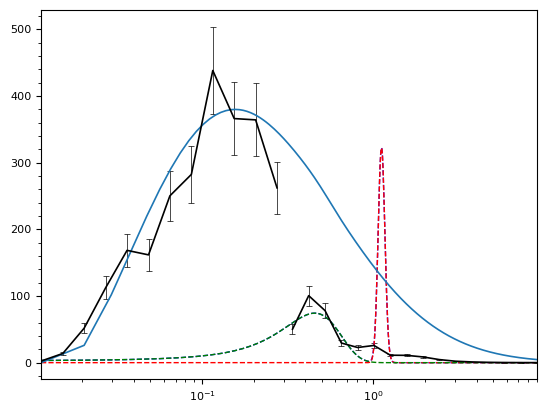

In [14]:
bin_mean_fit = np.linspace(min(NS_OPS_bin_mean), max(NS_OPS_bin_mean), 1000)
fig, ax = plt.subplots()

ax, fit_params, fit_errors, df_mean = plot_fitted_mean(ax, timestamps_exp[0], NS_OPS_number['Exp1'], NS_OPS_keys, 'Time', 0.15, NS_OPS_bin_mean, NS_OPS_cut, 0.3, [40, 25, 0.13, 0.05, 0.45, 0.1], 'log + gauss', ['k', 'b', 'r', 'g'])
ax.plot(bin_mean_fit, lognorm_gauss(bin_mean_fit, 500, 1, 0.015, 1.4, 0.45, 0.1))

ax.set_xscale('log')

In [15]:
df_mean.to_csv('Exp1.csv')

[2.91607458e-01 1.82773052e+00 6.00834577e+00 1.52871164e+01
 1.91851489e+01 2.21071708e+01 2.82077496e+01 3.88949028e+01
 4.91149433e+01 5.04588026e+01 4.08348780e+01 2.84235360e+01
 4.80175944e+00 9.50194739e+00 7.43004052e+00 2.80740855e+00
 2.15792882e+00 2.46066852e+00 1.06608394e+00 1.04680965e+00
 8.18765646e-01 4.42613555e-01 2.06559844e-01 1.06073805e-01
 4.87719803e-02 1.93526510e-02 1.01446264e-02 5.43280258e-03]
[4.37411187e-02 2.74159578e-01 9.01251865e-01 2.29306746e+00
 2.87777234e+00 3.31607562e+00 4.23116244e+00 5.83423542e+00
 7.36724150e+00 7.56882039e+00 6.12523170e+00 4.26353040e+00
 7.20263916e-01 1.42529211e+00 1.11450608e+00 4.21111282e-01
 3.23689323e-01 3.69100278e-01 1.59912592e-01 1.57021447e-01
 1.22814847e-01 6.63920332e-02 3.09839766e-02 1.59110708e-02
 7.31579705e-03 2.90289764e-03 1.52169396e-03 8.14920388e-04]
<ValueView p1=45.63078204629727 p2=24.567782153041744 mu1=0.12115460379971646 sigma1=0.03277534034736973 mu2=0.8729581962836769 sigma2=0.3698211

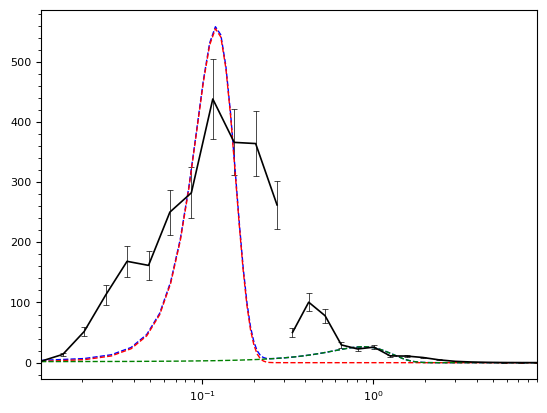

In [10]:
bin_mean_fit = np.linspace(min(NS_OPS_bin_mean), max(NS_OPS_bin_mean), 1000)
fig, ax = plt.subplots()

plot_fitted_mean(ax, timestamps_exp[0], NS_OPS_number['Exp1'], NS_OPS_keys, 'Time', 0.15, NS_OPS_bin_mean, NS_OPS_cut, 0.3, [55, 25, 0.13, 0.06, 0.45, 0.1], 'double', ['k', 'b', 'r', 'g'])

ax.set_xscale('log')

[2.91607458e-01 1.82773052e+00 6.00834577e+00 1.52871164e+01
 1.91851489e+01 2.21071708e+01 2.82077496e+01 3.88949028e+01
 4.91149433e+01 5.04588026e+01 4.08348780e+01 2.84235360e+01
 4.80175944e+00 9.50194739e+00 7.43004052e+00 2.80740855e+00
 2.15792882e+00 2.46066852e+00 1.06608394e+00 1.04680965e+00
 8.18765646e-01 4.42613555e-01 2.06559844e-01 1.06073805e-01
 4.87719803e-02 1.93526510e-02 1.01446264e-02 5.43280258e-03]
[4.37411187e-02 2.74159578e-01 9.01251865e-01 2.29306746e+00
 2.87777234e+00 3.31607562e+00 4.23116244e+00 5.83423542e+00
 7.36724150e+00 7.56882039e+00 6.12523170e+00 4.26353040e+00
 7.20263916e-01 1.42529211e+00 1.11450608e+00 4.21111282e-01
 3.23689323e-01 3.69100278e-01 1.59912592e-01 1.57021447e-01
 1.22814847e-01 6.63920332e-02 3.09839766e-02 1.59110708e-02
 7.31579705e-03 2.90289764e-03 1.52169396e-03 8.14920388e-04]
<ValueView p1=10.072971363906314 p2=23.879369293521293 mu1=-0.560190458709743 sigma1=3.7777828237709654 mu2=1.3131819411379022 sigma2=0.74990211

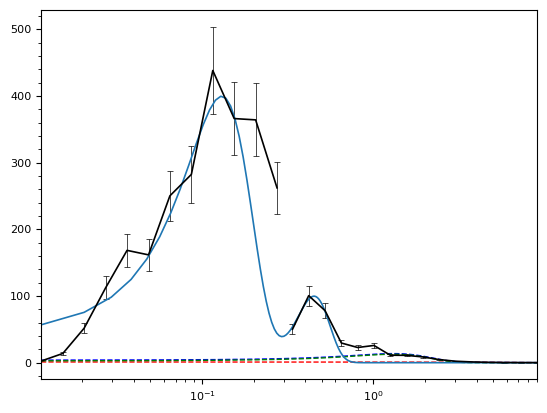

In [11]:
bin_mean_fit = np.linspace(min(NS_OPS_bin_mean), max(NS_OPS_bin_mean), 1000)
fig, ax = plt.subplots()

plot_fitted_mean(ax, timestamps_exp[0], NS_OPS_number['Exp1'], NS_OPS_keys, 'Time', 0.15, NS_OPS_bin_mean, NS_OPS_cut, 0.3, [10, 10, 1, 1, 1, 1], 'double', ['k', 'b', 'r', 'g'])
ax.plot(bin_mean_fit, d_gauss(bin_mean_fit, 60, 25, 0.13, 0.06, 0.45, 0.1))

ax.set_xscale('log')